# Expected Improvement BO


In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# Import the class
import torch
import yaml

## Customizing the UpperConfidenceBound Generator
First lets examine the possible options that we can specify for the
UpperConfidenceBound generator. We can use these keys to customize optimization.

In [2]:
from xopt.generators import get_generator_and_defaults
ei_gen, ei_options = get_generator_and_defaults("expected_improvement")
print(yaml.dump(ei_options.dict()))

acq:
  monte_carlo_samples: 128
  proximal_lengthscales: null
  use_transformed_proximal_weights: true
model:
  covar_modules: {}
  custom_constructor: null
  mean_modules: {}
  name: standard
  use_low_noise_prior: true
n_initial: 3
optim:
  max_travel_distances: null
  num_restarts: 20
  raw_samples: 20
  sequential: true
  use_turbo: false
use_cuda: false



In [3]:
from xopt.resources.test_functions.rosenbrock import make_rosenbrock_vocs, evaluate_rosenbrock
from xopt import Xopt, Evaluator

vocs = make_rosenbrock_vocs(2)

generator_options = ei_gen.default_options()
generator_options.optim.num_restarts = 20
generator_options.optim.max_travel_distances = [0.1, 0.1]

evaluator = Evaluator(function=evaluate_rosenbrock)
generator = ei_gen(vocs, generator_options)


In [4]:
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)

for i in range(20):
    X.step()
    print(f"step {i}: best: {X.data['y'].min()}")


step 0: best: 137.0400409172818
step 1: best: 137.0400409172818
step 2: best: 137.0400409172818
step 3: best: 137.0400409172818
step 4: best: 95.26810129161834
step 5: best: 17.22033994628439
step 6: best: 3.3812008092024866
step 7: best: 3.3812008092024866
step 8: best: 1.9571440464780667
step 9: best: 1.9571440464780667
step 10: best: 1.9571440464780667
step 11: best: 1.9571440464780667
step 12: best: 1.9571440464780667
step 13: best: 1.9571440464780667
step 14: best: 1.9571440464780667
step 15: best: 1.9571440464780667
step 16: best: 1.9571440464780667
step 17: best: 1.9571440464780667
step 18: best: 1.9571440464780667
step 19: best: 1.9571440464780667


## View output data

In [5]:
X.data

,x0,x1,y,xopt_runtime,xopt_error
1,-0.454238,1.367906,137.040041,0.000014,False
2,-0.762416,-1.616226,486.008239,0.000004,False
3,1.233394,-1.200286,740.736159,0.000003,False
4,1.614004,-1.202894,1450.389242,0.000012,False
5,1.214004,-1.602894,946.653754,0.000012,False
6,0.814004,-1.202894,348.042237,0.000013,False
7,0.414004,-0.802894,95.268101,0.000013,False
8,0.014004,-0.402894,17.220340,0.000013,False
9,0.414004,-0.002894,3.381201,0.000013,False
10,0.014004,0.397106,16.725946,0.000012,False


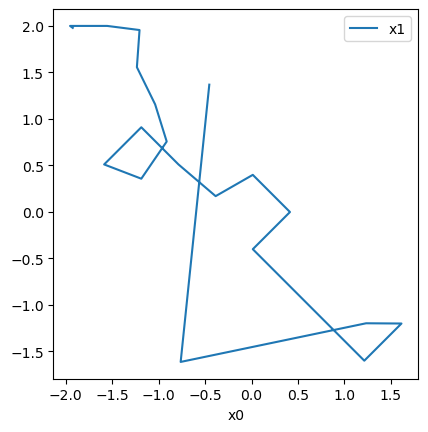

In [6]:
# plot results
ax = X.data.plot(*vocs.variable_names)
ax.set_aspect("equal")

## Visualize model used by upper confidence bound
Models are kept in a list, in this case that list has one element, the model
created for the objective `y1`.


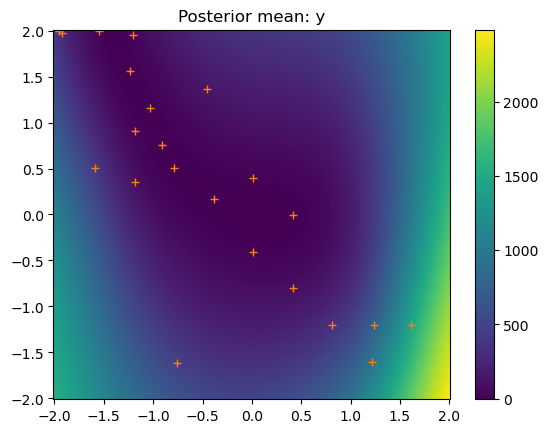

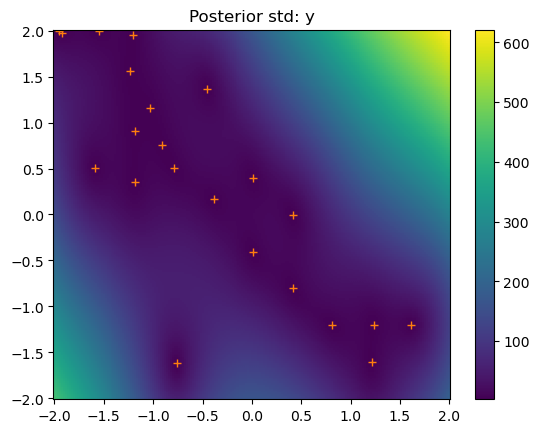

In [7]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = generator.vocs.bounds
model = generator.train_model(generator.data)

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    fig, ax = plt.subplots()
    ax.plot(*data[vocs.variable_names].to_numpy().T, "+C1")
    c = ax.pcolor(xx, yy, mean.reshape(n, n))
    fig.colorbar(c)
    ax.set_title(f"Posterior mean: {outputs[0]}")

    fig2, ax2 = plt.subplots()
    ax2.plot(*data[vocs.variable_names].to_numpy().T, "+C1")
    c = ax2.pcolor(xx, yy, std.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title(f"Posterior std: {outputs[0]}")

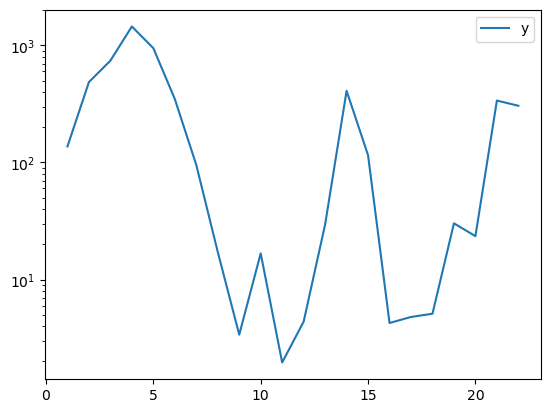

In [8]:
ax = X.data.plot(y="y", logy=True)

In [9]:
# Cleanup
!rm dump.yaml

rm: cannot remove 'dump.yaml': No such file or directory
